In [28]:
import sys
import os
import numpy as np
from pathlib import Path
import cv2
# Add the path to 'lib' directory
sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

# Now try importing
from calibration.cv2api.calibrate import read_chessboards,calibrate_camera
from calibration.cv2api.detect import detect_pose
from config.ConfigManager import ConfigManager
from calibration.json_utils.json_functions import generate_json_for_images

config_manager = ConfigManager('config.json')

ARUCO_DICT = cv2.aruco.DICT_6X6_250
SQUARES_VERTICALLY = 13
SQUARES_HORIZONTALLY = 9
SQUARE_LENGTH = 0.03
MARKER_LENGTH = 0.02

dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
print("Setup with this board", board.getDictionary())

def calibrate_and_write(project_name,  output_folder):

    image_files = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith(".jpg") or f.endswith(".png") or f.endswith(".bmp")]
    image_files.sort()  # Ensure files are in order

    allCorners,allIds,imsize,num_of_detected_markers=read_chessboards(image_files,board)

    print(allCorners)


    ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize,board)
    print(ret,mtx)
    if(ret!=-1):
        np.save(os.path.join(output_folder,"camera_matrix.npy"), mtx)
        np.save(os.path.join(output_folder,"camera_dist_coeff.npy"),dist)
        config_manager.update_project(project_name, {"calibrated": True, "camera_matrix": mtx.tolist(),
                                                "dist_coeff": dist.tolist()})
        return mtx,dist
    else:
        print("no calibration data were found")
        return None, None 



input = "../node-red/projects/calib3/"

output_folder = input
project_name = "test"
mtx = None
dist = None
num_of_images = 40

if(os.path.isdir(input)):
    config_manager.update_project(project_name, {"images": output_folder})
    mtx,dist = calibrate_and_write(project_name, output_folder)
else:
    err = os.system(f"sfextract --frame-count {num_of_images} {input} --output {output_folder}")  
    if(err):
        print("Error occured while generating images from video")
    else:
        config_manager.update_project(project_name, {"images": output_folder})
        mtx,dist = calibrate_and_write("test", output_folder)

if mtx is not None and mtx.any():
    generate_json_for_images(input,os.path.join(input,"transforms_centered.json"),mtx,dist,board,colmap = True)
else:
    print("Cannot do detection, to little charuco markers were found")


Setup with this board < cv2.aruco.Dictionary 0x7f37f25d7230>
POSE ESTIMATION STARTS:
Using this board  < cv2.aruco.Dictionary 0x7f37f25d7230>
=> Processing image ../node-red/projects/calib3/frame0000.bmp
(1368, 2552)
=> Processing image ../node-red/projects/calib3/frame0001.bmp
(1368, 2552)
=> Processing image ../node-red/projects/calib3/frame0002.bmp
(1368, 2552)
=> Processing image ../node-red/projects/calib3/frame0003.bmp
(1368, 2552)
=> Processing image ../node-red/projects/calib3/frame0004.bmp
(1368, 2552)
=> Processing image ../node-red/projects/calib3/frame0005.bmp
(1368, 2552)
=> Processing image ../node-red/projects/calib3/frame0006.bmp
(1368, 2552)
=> Processing image ../node-red/projects/calib3/frame0007.bmp
(1368, 2552)
=> Processing image ../node-red/projects/calib3/frame0008.bmp
(1368, 2552)
=> Processing image ../node-red/projects/calib3/frame0009.bmp
(1368, 2552)
=> Processing image ../node-red/projects/calib3/frame0010.bmp
(1368, 2552)
=> Processing image ../node-red/p

[ WARN:0@1975.808] global aruco.cpp:77 estimatePoseCharucoBoard estimatePoseCharucoBoard: 
OpenCV(4.10.0) /io/opencv/modules/calib3d/src/calibration.cpp:1280: error: (-2:Unspecified error) in function 'void cvFindExtrinsicCameraParams2(const CvMat*, const CvMat*, const CvMat*, const CvMat*, CvMat*, CvMat*, int)'
> DLT algorithm needs at least 6 points for pose estimation from 3D-2D point correspondences. (expected: 'count >= 6'), where
>     'count' is 4
> must be greater than or equal to
>     '6' is 6



19
frame0010.bmp True
19
frame0011.bmp True
2
Not enough corners for pose estimation.
frame0012.bmp False No markers detected:/
0
Not enough markers detected.
frame0013.bmp False No markers detected:/
0
Not enough markers detected.
frame0014.bmp False No markers detected:/
24
frame0015.bmp True
22
frame0016.bmp True
23
frame0017.bmp True
17
frame0018.bmp True
13
frame0019.bmp True
1
Not enough corners for pose estimation.
frame0020.bmp False No markers detected:/
18
frame0021.bmp True
16
frame0022.bmp True
17
frame0023.bmp True
19
Not enough corners for pose estimation.
frame0024.bmp False No markers detected:/
0
Not enough markers detected.
frame0025.bmp False No markers detected:/
0
Not enough markers detected.
frame0026.bmp False No markers detected:/
0
Not enough markers detected.
frame0027.bmp False No markers detected:/
3
Not enough corners for pose estimation.
frame0028.bmp False No markers detected:/
4
Not enough corners for pose estimation.
frame0029.bmp False No markers detec

In [20]:
mtx[1,1] = 2000

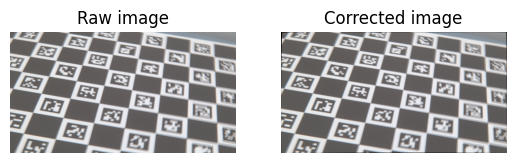

16


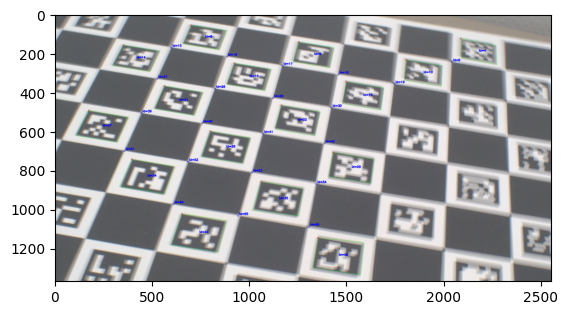

(True, array([[-0.88563881],
       [-0.04287403],
       [ 0.16707825]]), array([[-0.18836085],
       [-0.12035315],
       [ 0.58000016]]))


In [29]:
from matplotlib import pyplot as plt
import cv2


def undistort_image(image, camera_matrix, dist_coeffs):
    h, w = image.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)
    return undistorted_image

i=5 # select image id
plt.figure()
frame = cv2.imread(input+"frame0003.bmp")
img_undist = undistort_image(frame,mtx,dist)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()
print(detect_pose(frame,mtx,dist,board = board,debug_viz = True))


In [30]:
cv2.imwrite("correct_calibration.png",img_undist)

True

2
Not enough markers detected.
(False, None, None)


In [2]:
from lib.calibration.viz_utils.viz_cameras import camera_with_frustums 

In [4]:
camera_with_frustums("../node-red/projects/benchmark_4x4_phone/transforms_centered.json","../node-red/projects/benchmark_4x4_phone/cameras.html")